# ***Deep Learning based Car Identification***
##### *- Automotive, Surveillance, Object Detection & Localisation*

***Project By:***<br>
Premjeet Kumar https://www.linkedin.com/in/premjeet-kumar/<br>
Hari Samynaath S https://www.linkedin.com/in/harinaathan/<br>
Veena Raju https://www.linkedin.com/in/veena-raju-1b16b513b/<br>
Javed Bhai https://www.linkedin.com/in/javedbhai/<br>
Surabhi Joshi https://www.linkedin.com/in/surabhi-joshi-4452788/<br>

***Project For:***<br>
Captstone project for **Post Graduate Program in Artificial Intelligence and Machine Learning**<br>
with *GreatLakes & Texas McCombs School of Business, The University of Texas at Austin*

**CONTEXT:**<br>
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is predicted from the image of interest. For example a car moving on the road can be easily identi ied by a camera as make of the car, type, colour, number plates etc.<br><br>
**DATA DESCRIPTION:**<br>
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.<br>
<br>
‣ *Train Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Test Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Train Annotation:* Consists of bounding box region for training images.<br>
‣ *Test Annotation:* Consists of bounding box region for testing images.<br>

### **MILESTONE 1:**
‣ *Step 1:* Import the data<br>
‣ *Step 2:* Map training and testing images to its classes.<br>
‣ *Step 3:* Map training and testing images to its annotations.<br>
‣ *Step 4:* Display images with bounding box<br>
‣ *Output:* Images mapped to its class and annotation ready to be used for deep learning<br>

### **MILESTONE 2:**
‣ *Input:* Output of milestone 1<br>
‣ *Step 1:* Design, train and test CNN models to classify the car.<br>
‣ *Step 2:* Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or
mask over the area of interest.<br>
‣ *Output:* Pickled model to be used for future prediction<br>

In [1]:
import tensorflow as tf
import numpy as np
import os, pickle, re
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)

In [2]:
# import models to environment
from tensorflow.keras.optimizers import Adagrad,Adam,SGD,RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet152V2,ResNet50V2,ResNet101V2
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0,EfficientNetV2B1,EfficientNetV2B2,EfficientNetV2B3
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S,EfficientNetV2M,EfficientNetV2L
from tensorflow.keras.applications.densenet import DenseNet169,DenseNet201,DenseNet121
from tensorflow.keras.applications.nasnet import NASNetMobile

In [3]:
# list down parameters and the test ranges
optims = [Adam(), SGD(momentum=0.1)]

patiences = [4,8]
slopes = [0.3,0.5]
factors = [0.1,0.3]

uFreezePercents = [0,0.3,0.7]

learningRates = [1e-3,1e-7]
lossBalancing = [0.2,0.8]

dOuts = [0.5,0.7]
lmbdas = [0.1,0.01]

# create grid of parameters
pGrid = [{'optimizer':o,
          'patience':p,'slope':s,'factor':f,
          'unFreezeRatio':r,
          'learning_rate':lr,'lossBalance':lb,
          'dropOut':do,'lmbda':lmb}
         for o in optims
         for p in patiences for s in slopes for f in factors
         for r in uFreezePercents
         for lr in learningRates for lb in lossBalancing
         for do in dOuts for lmb in lmbdas
        ]
print("Parameter grid count: {:,d}".format(len(pGrid)))

Parameter grid count: 768


In [4]:
# define a transfer learning network mapped to our targets
def transferNET(application,input_size,dOut,lmbda):    
    
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input,GlobalMaxPool2D,Dense,BatchNormalization,Dropout
    
     # Random consistency seed
    tf.random.set_seed(100)
    
    # load application
    tNet = application(input_shape=input_size[1:],include_top=False, weights='imagenet')
    
    # flatten with pooling
    pool = GlobalMaxPool2D(name="CustomLayerStart")(tNet.output)
    
    # classifier branch for car names
    nameBranch = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(lmbda))(pool)
    Nbn1 = BatchNormalization()(nameBranch)
    Ndo1 = Dropout(dOut)(Nbn1)
    Nhid1 = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(lmbda))(Ndo1)
    Nbn2 = BatchNormalization()(Nhid1)
    Ndo2 = Dropout(dOut)(Nbn2)
    classifier = Dense(196,activation='softmax',name="names")(Ndo2)
    
    # regression branch for bounding boxes
    boxBranch = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(lmbda))(pool)
    Bbn1 = BatchNormalization()(boxBranch)
    Bdo1 = Dropout(dOut)(Bbn1)
    Bhid1 = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(lmbda))(Bdo1)
    Bbn2 = BatchNormalization()(Bhid1)
    Bdo2 = Dropout(dOut)(Bbn2)
    bBox = Dense(4,activation='relu',name="boxes")(Bdo2)
    
    # assemble the network
    model = Model(inputs=tNet.inputs,outputs=[classifier,bBox])
    
    # freeze application layers and open classifer & regressor for training
    for layer in model.layers[:-15]:
        layer.trainable = False
    
    return model

In [8]:
models = [VGG16,VGG19,MobileNetV2,ResNet50V2,EfficientNetV2S,DenseNet201,NASNetMobile]
compareResults=pd.DataFrame()
for model in models:
    fname = os.path.join('deployables',model.__name__,"%s_attrib.gl"%model.__name__)
    with open(fname, 'rb') as fh:
        attributes = pickle.load(fh)
    """if compareResults.shape[0]==0:
        compareResults = pd.DataFrame(columns=list(attributes['evalResults'].keys()),dtype=object)"""
    
    compareResults = compareResults.append(attributes['evalResults'],ignore_index=True)
    
compareResults

,name,target_size,batch_size,optimizer,patience,slope,factor,learning_rate,lossWeights,epochs,verbose,logs,loss,names_loss,boxes_loss,names_CategoricalAccuracy,names_Precision,names_Recall,boxes_IoU,val_loss,val_names_loss,val_boxes_loss,val_names_CategoricalAccuracy,val_names_Precision,val_names_Recall,val_boxes_IoU,steps_per_epoch,validation_steps
0,VGG16,"(224, 224)",32,Adam,15,0.15,0.1,0.001,"{'names': 0.5, 'boxes': 0.5}",30,1,"{'loss': [5.587075233459473, 3.966358661651611...",0.844168,0.831028,0.013140,0.859375,0.978552,0.656742,0.646943,2.857366,2.844716,0.012650,0.327067,0.650644,0.163471,0.651080,NaN,NaN
1,VGG19,"(224, 224)",32,Adam,15,0.15,0.1,0.001,"{'names': 0.5, 'boxes': 0.5}",30,1,"{'loss': [5.638175010681152, 4.074068546295166...",0.952510,0.937004,0.015506,0.838091,0.980834,0.604454,0.618246,3.030715,3.015413,0.015301,0.303909,0.626506,0.135956,0.620036,NaN,NaN
2,MobileNetV2,"(224, 224)",32,Adam,15,0.15,0.1,0.001,"{'names': 0.5, 'boxes': 0.5}",30,1,"{'loss': [5.118948459625244, 3.445307493209839...",0.452112,0.440491,0.011621,0.928765,0.982900,0.869833,0.650052,2.506006,2.494308,0.011697,0.389442,0.670391,0.224104,0.647654,NaN,NaN
3,ResNet50V2,"(224, 224)",32,Adam,15,0.15,0.1,0.001,"{'names': 0.5, 'boxes': 0.5}",30,1,"{'loss': [5.000739574432373, 3.436673164367676...",0.369423,0.350934,0.018489,0.935778,0.981474,0.912525,0.587236,2.480897,2.462386,0.018511,0.408989,0.657504,0.259089,0.589307,NaN,NaN
4,EfficientNetV2S,"(224, 224)",32,Adam,15,0.15,0.1,0.001,"{'names': 0.5, 'boxes': 0.5}",30,1,"{'loss': [5.972702503204346, 5.568402290344238...",4.983481,4.955740,0.027741,0.037032,0.000000,0.000000,0.511724,5.245408,5.218029,0.027380,0.016434,0.000000,0.000000,0.514779,NaN,NaN
5,DenseNet201,"(224, 224)",32,Adam,15,0.15,0.1,0.001,"{'names': 0.5, 'boxes': 0.5}",2,1,"{'loss': [5.747513771057129, 4.238009452819824...",3.653059,3.343921,0.309137,0.230315,0.659529,0.037894,0.004085,4.151174,3.840998,0.310175,0.139940,0.412234,0.019298,0.029028,100.0,10.0
6,NASNetMobile,"(224, 224)",32,Adam,15,0.15,0.1,0.001,"{'names': 0.5, 'boxes': 0.5}",30,1,"{'loss': [4.982983589172363, 3.866465091705322...",1.269307,1.258898,0.010408,0.728716,0.958167,0.414247,0.667567,2.815521,2.804810,0.010710,0.305154,0.639756,0.117405,0.665775,NaN,NaN


In [9]:
KPIs = compareResults[['name','loss','names_CategoricalAccuracy','boxes_IoU',
                                'val_loss','val_names_CategoricalAccuracy','val_boxes_IoU']]
KPIs.sort_values(by='val_names_CategoricalAccuracy',ascending=False)

,name,loss,names_CategoricalAccuracy,boxes_IoU,val_loss,val_names_CategoricalAccuracy,val_boxes_IoU
3,ResNet50V2,0.369423,0.935778,0.587236,2.480897,0.408989,0.589307
2,MobileNetV2,0.452112,0.928765,0.650052,2.506006,0.389442,0.647654
0,VGG16,0.844168,0.859375,0.646943,2.857366,0.327067,0.651080
6,NASNetMobile,1.269307,0.728716,0.667567,2.815521,0.305154,0.665775
1,VGG19,0.952510,0.838091,0.618246,3.030715,0.303909,0.620036
5,DenseNet201,3.653059,0.230315,0.004085,4.151174,0.139940,0.029028
4,EfficientNetV2S,4.983481,0.037032,0.511724,5.245408,0.016434,0.514779


In [5]:
from lib.networkPipe import Pipe

2022-07-31 14:00:48.023382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 14:00:48.049584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 14:00:48.049842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 14:00:48.050442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
logdir = "logs"
%load_ext tensorboard
%tensorboard --logdir logs

In [12]:
gIndex = np.arange(len(pGrid))
for index in np.random.choice(gIndex,30,replace=False):
    
    print("gridPosition used : %03d"%index)
    
    gPoint = pGrid[index]    
    # generator parameters
    gParams = dict(target_size=(224,224),batch_size=32)
    # model creation parameters
    mParams = dict(application=ResNet50V2,dOut=gPoint.get('dropOut'),lmbda=gPoint.get('lmbda'))
    # optimiser for compilation
    optim = gPoint.get('optimizer')
    # lr scheduler parameters
    lrParams = dict(patience=gPoint.get('patience'),slope=gPoint.get('slope'),factor=gPoint.get('factor'))
    # earlyStop parameters
    #eSparams = dict(patience=int(gPoint.get('patience')*3.1),slope=gPoint.get('slope')*0.5)
    eSparams = dict()
    # model fitting parameters
    fParams = dict(epochs=30,verbose=0,steps_per_epoch=50,validation_steps=10)
    # trainability scheduler parameters
    if gPoint.get('unFreezeRatio')==0:
        trParams = dict() 
    else:
        trParams = dict(uncontrolled=-15,schedule={int(gPoint.get('patience')*2.8):gPoint.get('unFreezeRatio')})
    # other hyper parameters
    lRate = gPoint.get('learning_rate')
    lBalance = gPoint.get('lossBalance')
    gridPoint = dict(learning_rate=lRate,lossWeights={'names':lBalance,'boxes':1-lBalance})
    
    pp = Pipe(generatorParams=gParams,modelFunc=transferNET,modelName="ResNet50V2_hTune_%03d"%index,modelParams=mParams)
    pp.compiler(optim=optim,lrScheduleParams=lrParams,eStopParams=eSparams,
                trainabilityParams=trParams,gridPoint=gridPoint,sBest=False)
    pp.fit(gridPoint=gridPoint,fitParams=fParams)
    pp.evaluate()
    pp.htuneSave()

gridPosition used : 489


imScanTest: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:03<00:00, 53.40it/s]
2022-07-30 00:32:38.326589: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-30 00:32:40.018558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 00:33:10.028114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 487


2022-07-30 00:55:47.512971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 00:56:16.839976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 146


2022-07-30 01:19:09.548922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 01:19:40.540491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 672


2022-07-30 01:42:54.852345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 01:43:24.809501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 323


2022-07-30 02:06:30.394239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 02:07:01.609770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 758


2022-07-30 02:30:26.503942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 02:30:56.733865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 123


2022-07-30 02:53:57.342220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 02:54:28.164741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 643


2022-07-30 03:17:31.700605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 03:18:02.071899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 588


2022-07-30 03:41:00.600867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 03:41:31.449377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 097


2022-07-30 04:04:47.923868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 04:05:17.612968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 622


2022-07-30 04:28:41.150176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 04:29:10.795849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 132


2022-07-30 04:52:45.528712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 04:53:16.602101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 661


2022-07-30 05:16:41.133705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 05:17:12.871830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 689


2022-07-30 05:40:35.326024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 05:41:06.266506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 279


2022-07-30 06:04:17.981954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 06:04:49.245426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 750


2022-07-30 06:27:57.965199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 06:28:28.111382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 545


2022-07-30 06:51:36.246675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 06:52:06.573275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 516


2022-07-30 07:15:26.421792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 07:15:56.859499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 164


2022-07-30 07:39:13.704803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 07:39:45.410792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 043


2022-07-30 08:03:14.665465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 08:03:47.117854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 280


2022-07-30 08:27:32.191586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 08:28:02.864992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 281


2022-07-30 08:51:45.417142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 08:52:16.936634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 717


2022-07-30 09:16:05.382913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 09:16:37.109896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 526


2022-07-30 09:40:09.228798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 09:40:41.263332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 755


2022-07-30 10:04:06.632067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 10:04:37.544375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 562


2022-07-30 10:28:08.456790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 10:28:39.289292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 539


2022-07-30 10:51:21.774174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 10:51:52.093384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 042


2022-07-30 11:14:39.770655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 11:15:11.939027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 582


2022-07-30 11:38:29.403042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 11:39:00.873826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


gridPosition used : 002


2022-07-30 12:02:11.071999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 12:02:42.897864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
dirList = os.listdir('./deployables/')
tuneList = [os.path.join('./deployables',fname) 
            for fname in dirList 
            if re.search(r'(hTune)',fname) 
            and re.search(r'(attrib.gl)',fname)]

In [13]:
tuneLog = pd.DataFrame()
for fname in tuneList:
    with open(fname, 'rb') as fh:
        attributes = pickle.load(fh)        
    tuneLog = tuneLog.append(attributes['evalResults'],ignore_index=True)

In [14]:
KPIs = tuneLog[['name','loss','names_CategoricalAccuracy','boxes_IoU',
                'val_loss','val_names_CategoricalAccuracy','val_boxes_IoU']]
KPIs.sort_values(by='val_names_CategoricalAccuracy',ascending=False)

,name,loss,names_CategoricalAccuracy,boxes_IoU,val_loss,val_names_CategoricalAccuracy,val_boxes_IoU
7,ResNet50V2_hTune_357,3.096646,0.516609,0.647384,3.713136,0.309512,0.648093
23,ResNet50V2_hTune_213,4.162242,0.515010,0.395893,4.792305,0.303909,0.399777
22,ResNet50V2_hTune_164,3.724387,0.362082,0.606193,4.090173,0.223481,0.609967
50,ResNet50V2_hTune_097,4.609859,0.317667,0.508563,4.932710,0.217505,0.512276
30,ResNet50V2_hTune_279,4.098151,0.301058,0.481427,4.343278,0.213770,0.482655
20,ResNet50V2_hTune_132,4.763387,0.244094,0.572507,4.990209,0.183391,0.576064
5,ResNet50V2_hTune_323,4.761096,0.245940,0.400854,4.944709,0.182271,0.404170
4,ResNet50V2_hTune_291,4.787927,0.240773,0.456392,4.985533,0.180777,0.465225
21,ResNet50V2_hTune_146,6.324769,0.252584,0.013193,6.519183,0.174801,0.012665
18,ResNet50V2_hTune_102,5.848691,0.136319,0.281144,5.945723,0.115289,0.289173


In [6]:
pGrid[357]

{'optimizer': <keras.optimizers.optimizer_v2.adam.Adam at 0x7f69582c7ee0>,
 'patience': 8,
 'slope': 0.5,
 'factor': 0.3,
 'unFreezeRatio': 0.3,
 'learning_rate': 0.001,
 'lossBalance': 0.8,
 'dropOut': 0.5,
 'lmbda': 0.01}

imScanTest: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:03<00:00, 52.80it/s]


Epoch 1/40


2022-07-30 16:00:58.213178: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-30 16:00:59.958693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


229/229 [==============================] - ETA: 0s - loss: 13.3685 - names_loss: 5.1055 - boxes_loss: 0.6026 - names_CategoricalAccuracy: 0.0424 - names_Precision: 0.2404 - names_Recall: 0.0034 - boxes_IoU: -0.0935

2022-07-30 16:03:12.492087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


229/229 [==============================] - 151s 638ms/step - loss: 13.3685 - names_loss: 5.1055 - boxes_loss: 0.6026 - names_CategoricalAccuracy: 0.0424 - names_Precision: 0.2404 - names_Recall: 0.0034 - boxes_IoU: -0.0935 - val_loss: 9.4936 - val_names_loss: 4.2723 - val_boxes_loss: 0.2507 - val_names_CategoricalAccuracy: 0.0925 - val_names_Precision: 0.6667 - val_names_Recall: 0.0075 - val_boxes_IoU: 0.0758 - learning_rate: 0.0010 - Trainable: 15.0000 - lapTime: 151.0182
Epoch 2/40
229/229 [==============================] - 148s 648ms/step - loss: 8.0431 - names_loss: 4.0030 - boxes_loss: 0.2577 - names_CategoricalAccuracy: 0.1161 - names_Precision: 0.3875 - names_Recall: 0.0127 - boxes_IoU: 0.0533 - val_loss: 6.9119 - val_names_loss: 3.8428 - val_boxes_loss: 0.1362 - val_names_CategoricalAccuracy: 0.1212 - val_names_Precision: 0.4762 - val_names_Recall: 0.0125 - val_boxes_IoU: 0.2473 - learning_rate: 0.0010 - Trainable: 15.0000 - lapTime: 148.4243
Epoch 3/40
229/229 [===============

Epoch 18/40
229/229 [==============================] - 146s 638ms/step - loss: 2.2986 - names_loss: 1.5603 - boxes_loss: 0.0103 - names_CategoricalAccuracy: 0.5636 - names_Precision: 0.8225 - names_Recall: 0.3206 - boxes_IoU: 0.6669 - val_loss: 3.5708 - val_names_loss: 2.8150 - val_boxes_loss: 0.0333 - val_names_CategoricalAccuracy: 0.2862 - val_names_Precision: 0.5660 - val_names_Recall: 0.1125 - val_boxes_IoU: 0.4339 - learning_rate: 3.0000e-04 - Trainable: 15.0000 - lapTime: 146.1071
Epoch 19/40
229/229 [==============================] - 146s 637ms/step - loss: 2.2278 - names_loss: 1.5023 - boxes_loss: 0.0093 - names_CategoricalAccuracy: 0.5850 - names_Precision: 0.8248 - names_Recall: 0.3405 - boxes_IoU: 0.6794 - val_loss: 3.4562 - val_names_loss: 2.7188 - val_boxes_loss: 0.0253 - val_names_CategoricalAccuracy: 0.3150 - val_names_Precision: 0.5694 - val_names_Recall: 0.1025 - val_boxes_IoU: 0.5156 - learning_rate: 3.0000e-04 - Trainable: 15.0000 - lapTime: 145.7970
Epoch 20/40
229/

2022-07-30 18:07:20.438553: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./deployables/ResNet50V2_FINAL/ResNet50V2_FINAL/tfsave/assets


,name,target_size,batch_size,optimizer,patience,slope,factor,uncontrolled,schedule,learning_rate,lossWeights,epochs,verbose,logs,loss,names_loss,boxes_loss,names_CategoricalAccuracy,names_Precision,names_Recall,boxes_IoU,val_loss,val_names_loss,val_boxes_loss,val_names_CategoricalAccuracy,val_names_Precision,val_names_Recall,val_boxes_IoU
0,ResNet50V2_FINAL,"(224, 224)",32,Adam,24,0.25,0.3,-15,{22: 0.3},0.001,"{'names': 0.8, 'boxes': 0.19999999999999996}",40,1,"{'loss': [13.368462562561035, 8.04307460784912...",1.248332,0.677075,0.006295,0.901575,0.981873,0.726378,0.719278,3.068458,2.496808,0.006688,0.373008,0.688816,0.183267,0.715414


2022-07-30 18:07:31.939469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


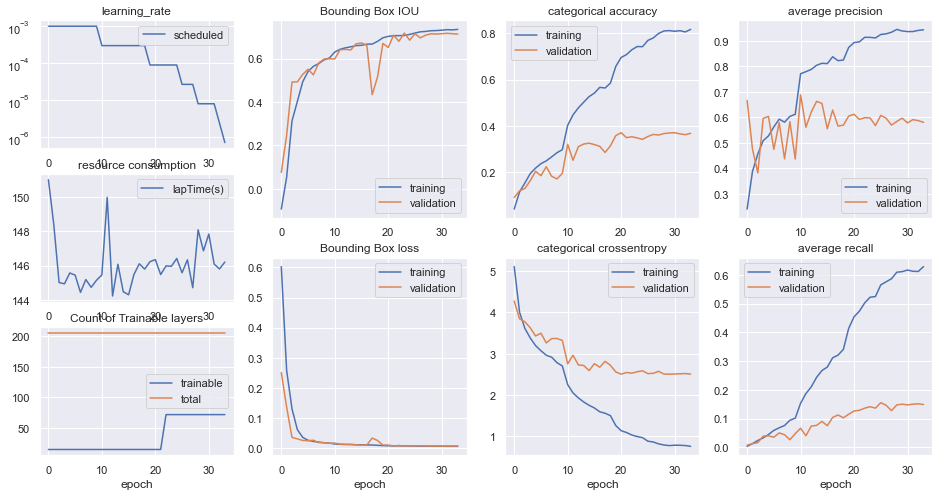

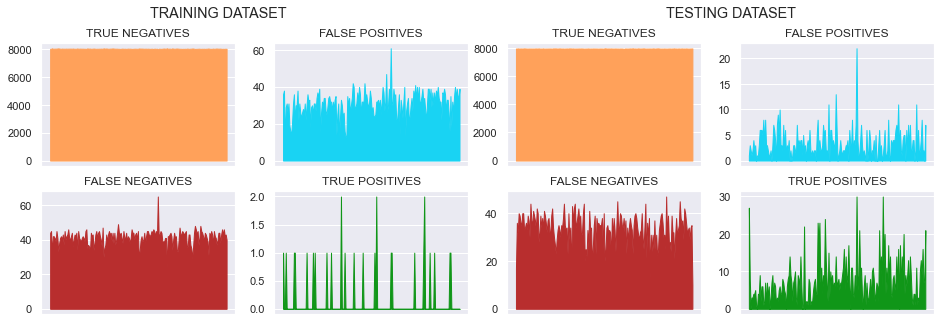

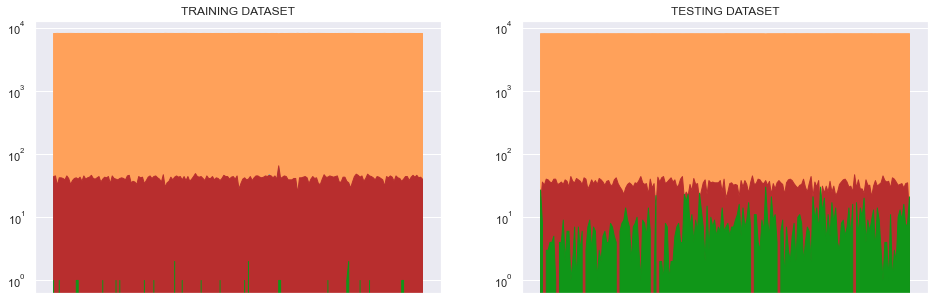

samples from TRAINING SET


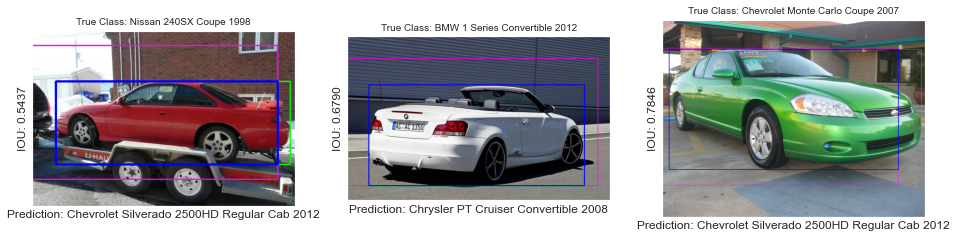

samples from TESTING SET


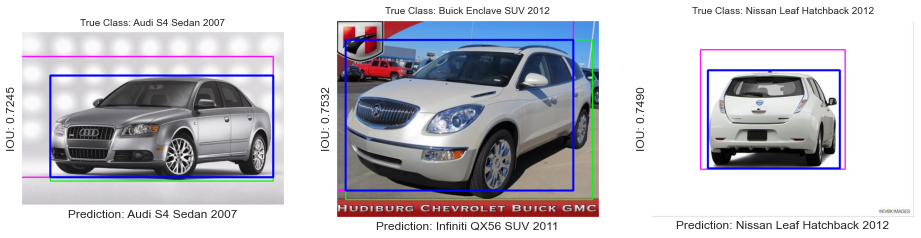

In [8]:
index=357

gPoint = pGrid[index]    
# generator parameters
gParams = dict(target_size=(224,224),batch_size=32)
# model creation parameters
mParams = dict(application=ResNet50V2,dOut=gPoint.get('dropOut'),lmbda=gPoint.get('lmbda'))
# optimiser for compilation
optim = gPoint.get('optimizer')
# lr scheduler parameters
lrParams = dict(patience=gPoint.get('patience'),slope=gPoint.get('slope'),factor=gPoint.get('factor'))
# earlyStop parameters
eSparams = dict(patience=int(gPoint.get('patience')*3.1),slope=gPoint.get('slope')*0.5)
# model fitting parameters
fParams = dict(epochs=40,verbose=1)
# trainability scheduler parameters
if gPoint.get('unFreezeRatio')==0:
    trParams = dict() 
else:
    trParams = dict(uncontrolled=-15,schedule={int(gPoint.get('patience')*2.8):gPoint.get('unFreezeRatio')})
# other hyper parameters
lRate = gPoint.get('learning_rate')
lBalance = gPoint.get('lossBalance')
gridPoint = dict(learning_rate=lRate,lossWeights={'names':lBalance,'boxes':1-lBalance})

pp = Pipe(generatorParams=gParams,modelFunc=transferNET,modelName="ResNet50V2_FINAL",modelParams=mParams)
pp.compiler(optim=optim,lrScheduleParams=lrParams,eStopParams=eSparams,
            trainabilityParams=trParams,gridPoint=gridPoint,sBest=False)
pp.fit(gridPoint=gridPoint,fitParams=fParams)
pp.evaluate()
pp.save()
pp.report()

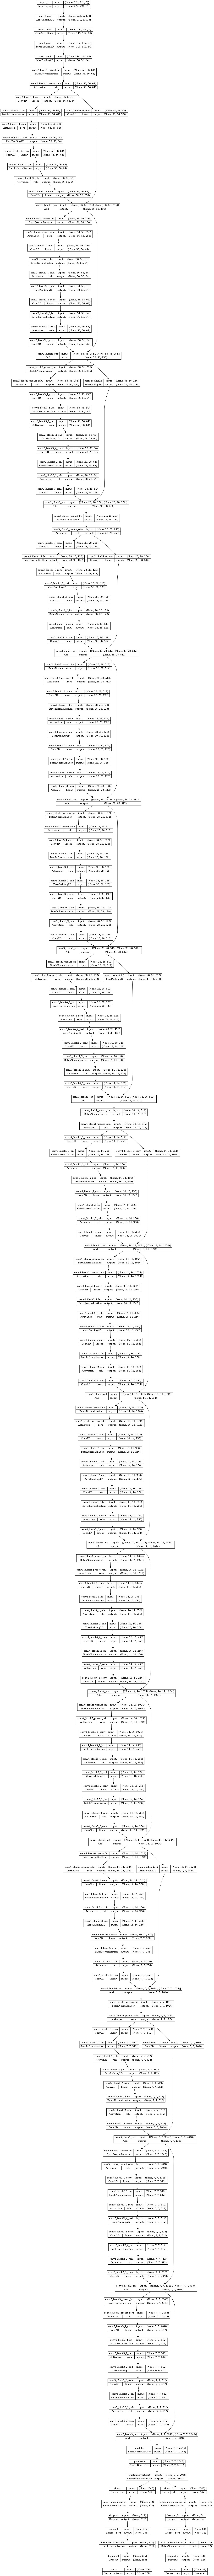

In [11]:
# visualise the final model in full topology
from tensorflow.keras.utils import plot_model
plot_model(pp.model,show_shapes=True,show_layer_activations=True,expand_nested=False)